# 4 Modeling

In the previous notebook, we prepared our data for training and wrote some functions to help us achieve that. We also generated a baseline model and tried some preliminary modeling (without any hyper parameter tunning).

In this notebook we will biuld robust models to do load forecasting using **`Elastic Net`**, **`XGB`** and **`LightGBM`**. In the next notebook we will aslo utilize the **`SARIMAX`** method to forecast and then compare it with the aformentioned models.

## 4.1 Contents
 * 4 [Modeling](#4-Modeling)  
 * 4.1 [Contents](#4.1-Contents)  
 * 4.2 [Import libraries](#4.2-Import-libraries)  
 * 4.3  [Load datasets](#4.3-Load-datasets)  
 * 4.4  [Defining helper functions](#4.4-Defining-helper-functions)
 * 4.5  [Adding cyclic Fourier terms](#4.5-Adding-cyclic-Fourier-terms)
 * 4.6  [Splitting train-test datasets](#4.6-Splitting-train-test-datasets)
 * 4.7 [Modeling and hyper parameter tunning](#4.7-Modeling-and-hyper-parameter-tunning)
    * 4.7.1 [Elastic Net](#4.7.1-Elastic-Net)
    * 4.7.2 [Extreme gradient boosting(XGB)](#4.7.2-Extreme-gradient-boosting(XGB))
    * 4.7.3 [Light GBM](#4.7.3-Light-GBM)
 * 4.8 [Feature importance](#4.8-Feature-importance)
 * 4.9 [Comparison of model performance](#4.9-Comparison-of-model-performance)
 * 4.10 [Saving models](#4.10-Saving-models)
 * 4.11 [Summary](#4.11-Summary)
 * 4.12 [Next steps](#4.12-Next-steps)

## 4.2 Import libraries

In [119]:
#!pip install hyperopt
# !pip install shap

In [5]:
# Import relevant libraries

import os, types
import io, requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from timeit import default_timer as timer
import datetime as dt
import pickle

# sklearn functions
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
import lightgbm as gbm

# optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

# error metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import norm

from library.sb_utils import save_file

import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import shap

# 4.3 Load datasets

In [10]:
# Reading back the saved file to check it was written as intended
lagged_dict = np.load('./modified_data/lagged_dict.npy',allow_pickle='TRUE').item()
# train_dict = np.load('./modified_data/lagged_train_dict.npy',allow_pickle='TRUE').item()
# test_dict = np.load('./modified_data/lagged_test_dict.npy',allow_pickle='TRUE').item()

In [11]:
lagged_dict['Coast'].head()

,tempC,windspeedKmph,winddirDegree,precipMM,humidity,visibility,pressure,cloudcover,HeatIndexC,DewPointC,...,appr_temp_lag504,appr_temp_lag672,appr_temp_lag768,appr_temp_lag8064,appr_temp_lag8760,roll_mean,roll_median,roll_std,roll_min,roll_max
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,8.0,14.0,335.0,0.00,90.0,10.0,1026.0,70.0,8.0,7.0,...,1.855022,1.221840,21.756105,1.802891,6.385142,8689.593481,8983.254286,693.692186,7466.132671,9684.165433
2010-01-01 01:00:00,7.0,19.5,336.5,0.05,88.5,10.0,1027.5,76.0,7.0,5.5,...,1.640410,0.720318,15.895605,0.989257,5.422290,8673.585860,8983.254286,707.006814,7466.132671,9684.165433
2010-01-01 02:00:00,7.0,19.5,336.5,0.05,88.5,10.0,1027.5,76.0,7.0,5.5,...,1.640410,0.720318,15.895605,0.989257,5.422290,8671.454090,8983.254286,709.743461,7466.132671,9684.165433
2010-01-01 03:00:00,6.0,25.0,338.0,0.10,87.0,10.0,1029.0,82.0,6.0,4.0,...,1.425798,0.218796,10.035106,0.175623,4.459439,8679.994104,8983.254286,696.135884,7466.132671,9684.165433
2010-01-01 04:00:00,5.5,15.5,172.5,0.15,86.5,9.5,1029.0,51.5,5.5,3.5,...,1.880856,-0.276466,9.295545,0.124410,4.777614,8687.679231,8983.254286,683.047648,7503.767527,9684.165433


## 4.4 Defining helper functions

In [12]:
# extracting the name of the numeric features
df_numeric_features = lagged_dict['Coast'].copy()
df_numeric_features.drop(columns=['winddir16Point','dates','covid_confirmed','covid_deaths'], inplace=True)

df_numeric_features = df_numeric_features.select_dtypes(include=[np.number])
df_numeric_features.drop(columns=['load'],inplace=True) # drop 'load' as this is our target y value
numeric_features = df_numeric_features.columns

In [13]:
def SplitEncodeTranf(train_data,test_data,region):
    
    """ This function will read the name of the region and will perform the following steps:
        1. It will select the region from the training and test dictionaries
        2. Will drop the features mentioned above
        3. Encode the categorical features
        3. Split the data into X_train, X_test, y_train and y_test
        4. Apply standard scaling to the X_train and X_test datasets
    """
    
    
    cat_columns = ['weatherCategory','year','month','day','hour','weekday','holiday','working_day']

    # for training dataset
    
    df_encode_tr = train_data[region].copy()
    df_encode_tr.drop(columns=['winddir16Point','dates','covid_confirmed','covid_deaths'], inplace=True)
    [df_encode_tr[col].astype('category') for col in cat_columns] # ensures these are type object
    df_encode_tr = pd.get_dummies(df_encode_tr, drop_first = True) # encodes categorical features
   
    y_train = df_encode_tr.loc[:, 'load']
    X_train = df_encode_tr.drop(['load'], axis =1)
    
    # for test dataset
    
    df_encode_tst = test_data[region].copy()
    df_encode_tst.drop(columns=['winddir16Point','dates','covid_confirmed','covid_deaths'], inplace=True)
    [df_encode_tst[col].astype('category') for col in cat_columns] # ensures these are type object
    df_encode_tst = pd.get_dummies(df_encode_tst, drop_first = True) # encodes categorical features
   
    
    y_test = df_encode_tst.loc[:, 'load']
    X_test = df_encode_tst.drop(['load'], axis =1)
     
    # Use standard scaler to scale the numeric features
    
    scaler = StandardScaler()
    X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
    X_test[numeric_features] = scaler.transform(X_test[numeric_features])
    
    return X_train, X_test, y_train, y_test

In [14]:
# A funcation to compute the error metrics
def ErrorMetrics(observed, predicted, model_name = None):
    
    """ 
    This function will compute the error associated with a given model
        it will calculate the r2_score, MAE, MSE, RMSE and MAPE
        y_true = the actual target values
        y_pred = the predict values
    """
    
    R_squared = r2_score(observed,predicted)
    MAE = mean_absolute_error(observed,predicted)
    MSE = mean_squared_error(observed,predicted)
    RMSE = np.sqrt(MSE)
    MAPE = np.mean(np.abs((observed - predicted) / observed)) * 100
    
    print('Error metrics for {}'.format(model_name))
    print('R2 score = {:.4f}'.format(R_squared))
    print('MAE = {:.4f}'.format(MAE))
    #print('Mean squared error is {:.4f}'.format(MSE))
    print('RMSE =  {:.4f}'.format(RMSE))
    print('MAPE =  {:.4f}%'.format(MAPE))
    return R_squared, RMSE, MAPE 

In [15]:
# Plotting the actual hourly load

def load_plot(df, start_time = None, end_time = None):
    """ This function plots all the columns of the dataframe
    
        df - name of the dataframe
        start_time - the time stamp where you start the plot
        end_time - the time stamp where you end the plot
        start_time and end_time must be a string format"""

    if start_time != None:
        if (type(start_time) or type(end_time)) != str:
           raise Exception('start_time or end_time is not a string')
    
    ax_column = df.columns
    fig, ax = plt.subplots(8,1, figsize = (15,20))
    plt.subplots_adjust(hspace= 1.0)
    for i, zone in enumerate(ax_column):
        ax[i].plot(df[zone][start_time : end_time]) 
        ax[i].set_xlabel(zone, fontsize=12)
        ax[i].set_ylabel('Load (MW)', fontsize=12)
    return ax[i]

In [16]:
# A function to plot observed vs predicted electric load

def Plot_Pred(observed, predicted, model_name = None, scatter=False):
    
    """ This function will read the observed and predicted values
    and plots a line and scatter plots
    """
    fig,ax1 = plt.subplots(figsize=(15,6))
    ax1.plot(observed.index, observed.values, label = 'Observed')
    ax1.plot(observed.index, predicted, label = 'Predicted')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Load (MW)')
    ax1.set_title('Observed vs Predicted Load (%s)'% model_name)
    
    start_t = observed.index[-168]
    end_t = observed.index.max()
    ax1.set_xlim([start_t , end_t])
    plt.legend(loc='best', prop={'size':16})
    
    if scatter:
        fig,ax2 = plt.subplots(figsize=(6,6))
        minx = df_coast.load.min() - 500
        maxx = df_coast.load.max() + 500

        ax2.scatter(y_train,ln_model.predict(X_train), label = 'training data')
        ax2.scatter(y_test,ln_model.predict(X_test),marker='+',c='g', label = 'test data')
        ax2.set_xlabel('Actual values (MW)')
        ax2.set_ylabel('Predicted values (MW)')
        ax2.set_xlim([minx,maxx])
        ax2.set_ylim([minx,maxx])
        x = np.linspace(*ax2.get_xlim())
        ax2.plot(x,x,'r')

    plt.legend(loc='best', prop={'size':16})
    plt.show()

In [17]:
# Function to calculate residuals
def Residuals(observed, predicted):
    
    """ The function calculates the residuals (observed - predicted) values"""
    
    residuals = observed - predicted
    return residuals

In [18]:
def LowerUpperBound(residuals):
    
    """ the function computes the lower and upper bounds of a 95% confidence """
    
    mean = residuals.mean()
    std = residuals.std(ddof=1)
    upper_bound = norm.ppf(0.975, mean, std)
    lower_bound = norm.ppf(0.025, mean, std)
    
    return lower_bound, upper_bound

## 4.5 Adding cyclic Fourier terms

These features reflect the cyclic characteristic of the time of day and the type of day. Cyclic variables are extracted in order to capture the cyclic nature of load time series. For each cyclic period (frequency), a pair of variables is considered to represent the corresponding cycles:

                        c1(t)=sin(2πt / T)

                        c2(t) = cos(2πt / T)

For our case, we will generate the fourier terms for the `hour`, `day of week` and `day of year` variables.

In [19]:
def FourierTerms(data):
    
#     if type(data) is dict:
        
        fourier_dict = {}
        for key, values in data.items():
            df = data[key].copy()

            df['sin_hour'] = np.sin((2*np.pi*df.index.hour)/24)
            df['cos_hour'] = np.cos((2*np.pi*df.index.hour)/24)  
                                        
            df['sin_week'] = np.sin((2*np.pi*df.index.dayofweek)/7)
            df['cos_week'] = np.cos((2*np.pi*df.index.dayofweek)/7)  
                                        
            df['sin_year'] = np.sin((2*np.pi*df.index.dayofyear)/365.25)
            df['cos_year'] = np.cos((2*np.pi*df.index.dayofyear)/365.25)  
        
            fourier_dict[key] = df
        return fourier_dict

In [20]:
lag_fourier_dict = FourierTerms(lagged_dict)

In [22]:
# lag_fourier_dict['Coast'].info()

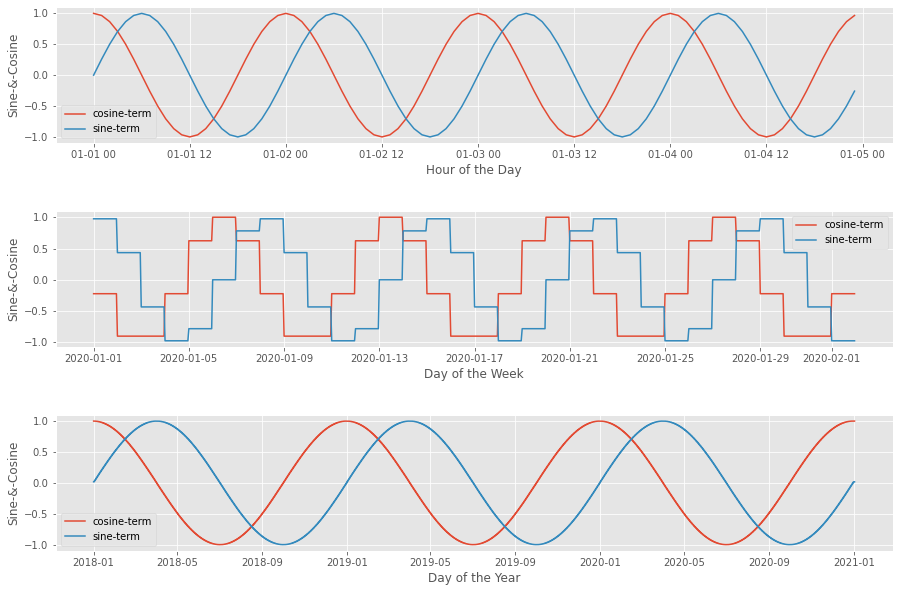

In [23]:
# plotting the fourier cyclic terms

fourier_reg = lag_fourier_dict['Coast']
plt.style.use('ggplot')
fig,ax = plt.subplots(3,1,figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
ax[0].plot(fourier_reg['cos_hour']['2020-01-01':'2020-01-04'], label = 'cosine-term')
ax[0].plot(fourier_reg['sin_hour']['2020-01-01':'2020-01-04'], label = 'sine-term')
ax[0].set_xlabel('Hour of the Day')
ax[0].set_ylabel('Sine-&-Cosine')
ax[0].legend(loc='best')

ax[1].plot(fourier_reg['cos_week']['2020-01-01':'2020-02-01'], label = 'cosine-term')
ax[1].plot(fourier_reg['sin_week']['2020-01-01':'2020-02-01'], label = 'sine-term')
ax[1].set_xlabel('Day of the Week')
ax[1].set_ylabel('Sine-&-Cosine')
ax[1].legend(loc='best')

ax[2].plot(fourier_reg['cos_year']['2018-01-01':'2021-01-01'], label = 'cosine-term')
ax[2].plot(fourier_reg['sin_year']['2018-01-01':'2021-01-01'], label = 'sine-term')
ax[2].set_xlabel('Day of the Year')
ax[2].set_ylabel('Sine-&-Cosine')
ax[2].legend(loc='best')
plt.show();

In [24]:
# create dictionaries for training and testing datasets
# we will use 8760 + 1 to make sure the separation happens at the end of 1 day
split_index = 8761
fourier_train_dict = {}
fourier_test_dict = {}
for key, values in lag_fourier_dict.items():
    fourier_train_dict[key] = lag_fourier_dict[key].iloc[:-split_index, :]
    fourier_test_dict[key] = lag_fourier_dict[key].iloc[-split_index:, :]

In [26]:
# fourier_train_dict['Coast'].info()

In [ ]:
# fourier_test_dict['Coast'].head()

## 4.6 Splitting train-test datasets

The data will be split into training and test data sets. Since we have huge amount of datasets, we will test building models with different subsets of the training data and compare it to using the whole training data sets.
A simple linear regression model will be used for this tests
<p>&nbsp;</p>

In [27]:
X_train, X_test, y_train, y_test = SplitEncodeTranf(fourier_train_dict,fourier_test_dict,'Coast')

In [28]:
# Basic Linear regression model including the fourier terms
# This model will be our benchmark for comparing the other models with different subsets of training datasets

ln_fourier_model = LinearRegression()
ln_fourier_model.fit(X_train,y_train)

LinearRegression()

In [29]:
ErrorMetrics(y_train,ln_fourier_model.predict(X_train),'Linear Regression with Fourier terms')

Error metrics for Linear Regression with Fourier terms
R2 score = 0.9970
MAE = 106.0756
RMSE =  145.7298
MAPE =  0.9608%


(0.9969683977428503, 145.72980334541796, 0.9607769701944284)

In [30]:
ErrorMetrics(y_test,ln_fourier_model.predict(X_test),'Linear Regression with Fourier terms')

Error metrics for Linear Regression with Fourier terms
R2 score = 0.9965
MAE = 112.9814
RMSE =  153.4725
MAPE =  0.9017%


(0.9964903362670591, 153.47247979562377, 0.9017275315133075)

In [31]:
# Truncate the training data to include 5 years 

X_train_5yr = X_train[-43848:]
y_train_5yr = y_train[-43848:]
# y_train_5yr.head(5)

In [32]:
ln_fourier_model2 = LinearRegression()
ln_fourier_model2.fit(X_train_5yr,y_train_5yr)

LinearRegression()

In [33]:
ErrorMetrics(y_train_5yr,ln_fourier_model2.predict(X_train_5yr),'Linear Regression with Fourier terms model2')

Error metrics for Linear Regression with Fourier terms model2
R2 score = 0.9972
MAE = 101.8952
RMSE =  141.0651
MAPE =  0.8634%


(0.997175783198833, 141.06510774108776, 0.8634284091463912)

In [34]:
ErrorMetrics(y_test,ln_fourier_model2.predict(X_test),'Linear Regression with Fourier terms model2')

Error metrics for Linear Regression with Fourier terms model2
R2 score = 0.9969
MAE = 104.8399
RMSE =  145.2359
MAPE =  0.8371%


(0.9968569434353451, 145.23585808657984, 0.8370890596833571)

In [35]:
# Truncate the training data to include 5 years 

X_train_3yr = X_train[-26304:]
y_train_3yr = y_train[-26304:]
ln_fourier_model3 = LinearRegression()
ln_fourier_model3.fit(X_train_3yr,y_train_3yr)
ErrorMetrics(y_train_3yr,ln_fourier_model3.predict(X_train_3yr),'Linear Regression with Fourier terms model3')
ErrorMetrics(y_test,ln_fourier_model3.predict(X_test),'Linear Regression with Fourier terms model3')

Error metrics for Linear Regression with Fourier terms model3
R2 score = 0.9973
MAE = 100.3581
RMSE =  139.9539
MAPE =  0.8328%
Error metrics for Linear Regression with Fourier terms model3
R2 score = 0.9969
MAE = 103.9727
RMSE =  144.1749
MAPE =  0.8296%


(0.9969026968372965, 144.17488527360024, 0.8295759574419583)

From the above tests, we can see that truncating the data to either 5 or 3 years gives slightly better results as compared to using the full data. Therefore, we will use the 3 years of training data when we do hyper parameter tunning and the 5 years when we fit the model with the best parameters.

## 4.7 Modeling and hyper parameter tunning

We will build models using Elatic Net, XGB and Light GBM methods. First we will use the default values and then perform hyper-parameter tunning.

For Elastic Net, we will ustilize the sklearn GridsearchCV to do hyper-parameter tunning, as it has fewer parameters to tune and is very fast.

For XGB and Light GBM, since there are many parameters to tune and can take long time, we will use the hyperOpt package (based on Bayesian optimization) to perform the hyper-parameter tunning. 



### Time series cross validation:

Cross-validation for time series is a bit different because time series have this temporal structure and one cannot randomly mix values in a fold while preserving this structure. With randomization, all time dependencies between observations will be lost. This is why we will have to use a more tricky approach in optimizing the model parameters such as "cross-validation on a rolling basis".

The idea is rather simple -- we train our model on a small segment of the time series from the beginning until some 𝑡
, make predictions for the next 𝑡+𝑛 steps, and calculate an error. Then, we expand our training sample to 𝑡+𝑛 value, make predictions from 𝑡+𝑛 until 𝑡+2∗𝑛, and continue moving our test segment of the time series until we hit the last available observation. As a result, we have as many folds as 𝑛 will fit between the initial training sample and the last observation. This can be established using the sklearn.model_selection's TimeSeriesSplit module. [Reference](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic09_time_series/topic9_part1_time_series_python.ipynb)
![image.png](time_series_cv.png)

We will use the TimeSeriesSplit method from sklearn to do the time series appropriate splitting for cross-validation

In [36]:
tscv = TimeSeriesSplit(n_splits=3)

###  4.7.1 Elastice Net

We have already built a model for elastic net using default parameters in the previous notebook. The performance is not that good, the MAPE and RMSE for the test dataset were 4.3% and 677.6 MW respectively.

Below we tune the parameters l1_ratio and alpha using GridSearchCV

In [30]:
start = timer()

Elastic_net_opt = ElasticNet()

l1_space = np.linspace(0, 1, 5)
alpha_space = np.logspace(-2, 0, 5)

param_grid = {'l1_ratio':l1_space,
              'alpha':alpha_space}

elc_rndmcv = GridSearchCV(Elastic_net_opt, param_grid, cv=tscv, verbose=0)
                               
elc_rndmcv.fit(X_train_3yr, y_train_3yr)
end = timer()
print('Time Elapsed is:',format(round(end - start)))

In [38]:
# ErrorMetrics(y_train_3yr,elc_rndmcv.predict(X_train_3yr),'Elastic Net Regression with Fourier terms model3')
# ErrorMetrics(y_test,elc_rndmcv.predict(X_test),'Elastice Net Regression with Fourier terms model3')

In [32]:
elc_rndmcv.best_estimator_

ElasticNet(alpha=0.1, l1_ratio=1.0)

In [37]:
# training a new elastic net model with the best parameters and using all the training data

elc_tunned = ElasticNet(alpha=0.1, l1_ratio=1.0)
elc_tunned.fit(X_train_5yr,y_train_5yr)

ErrorMetrics(y_train_5yr,elc_tunned.predict(X_train_5yr),'Best Elastic Net Regression with Fourier terms model3')
ErrorMetrics(y_test,elc_tunned.predict(X_test),'Best Elastice Net Regression with Fourier terms model3')

Error metrics for Best Elastic Net Regression with Fourier terms model3
R2 score = 0.9970
MAE = 104.8787
RMSE =  144.4372
MAPE =  0.8893%
Error metrics for Best Elastice Net Regression with Fourier terms model3
R2 score = 0.9966
MAE = 109.8954
RMSE =  151.0367
MAPE =  0.8775%


Objective did not converge. You might want to increase the number of iterations. Duality gap: 299230769.4042564, tolerance: 30895196.841302857


(0.9966008551529772, 151.03673619475245, 0.8774580340046263)

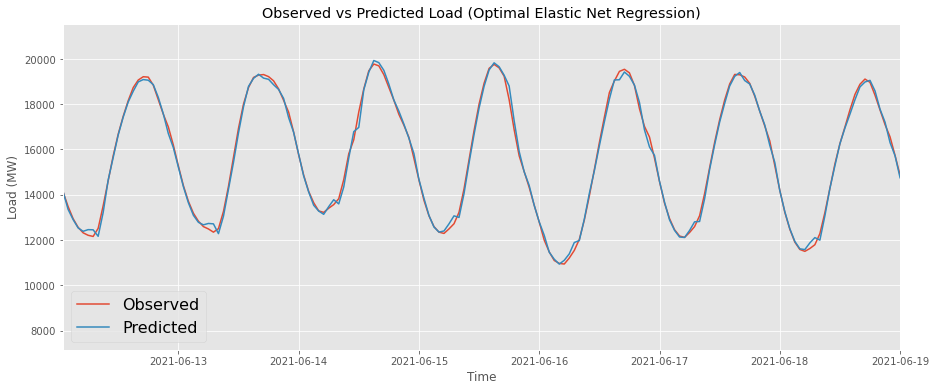

In [39]:
Plot_Pred(y_test, elc_tunned.predict(X_test), 'Optimal Elastic Net Regression')

After hyper parameter tunning, the performance of Elastic net has increased dramatically. The RMSE and MAPE errors for the test datasets are 150.02 and 0.87 respectively. These errors are also consistent with the errors from the training, indicating the model has generalized (no overfitting) very well.

### 4.7.2  Extreme Gradient Boosting (XGB)

First we will be running a simple XGB regressor using the default paramters to compare it the previous models. We will follow that with an optimized model, where we will tune hyper parameters.

In [41]:
# XGB regressor with default parameters
start = timer()

xgb_default = xgb.XGBRegressor()
xgb_default.fit(X_train_5yr, y_train_5yr)

ErrorMetrics(y_train_5yr,xgb_default.predict(X_train_5yr),' default XGB Regression on training data')
ErrorMetrics(y_test,xgb_default.predict(X_test),'default XGB Regression on test data')

end = timer()
print('Time Elapsed is:',format(round(end - start)))

Error metrics for  default XGB Regression on training data
R2 score = 0.9988
MAE = 68.9870
RMSE =  90.8889
MAPE =  0.5858%
Error metrics for default XGB Regression on test data
R2 score = 0.9952
MAE = 128.1782
RMSE =  179.8146
MAPE =  1.0065%
Time Elapsed is: 35


### Optimizing using hyperopt package

HYPEROPT: It is a powerful python library that search through an hyperparameter space of values . It implements three functions for minimizing the cost function,

    Random Search
    TPE (Tree Parzen Estimators)
    Adaptive TPE
    
https://medium.com/analytics-vidhya/hyperparameter-tuning-hyperopt-bayesian-optimization-for-xgboost-and-neural-network-8aedf278a1c9


In [183]:
# define the parameters to optimize

xgb_space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 0,20),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'colsample_bylevel' : hp.uniform('colsample_bylevel', 0.5,1),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'subsample' : hp.uniform('subsample', 0.3,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators',10,200,10),
        'learning_rate': hp.loguniform('learning_rate',np.log(0.001),np.log(1.0))
    }

In [184]:
# Define the objective function

def xgb_objective(xgb_space):
    xgb_model=xgb.XGBRegressor(n_estimators = int(xgb_space['n_estimators']), max_depth = int(xgb_space['max_depth']), 
                            gamma = xgb_space['gamma'],learning_rate = xgb_space['learning_rate'],
                            min_child_weight=xgb_space['min_child_weight'],subsample=xgb_space['subsample'],
                            reg_alpha = int(xgb_space['reg_alpha']),reg_lambda = xgb_space['reg_lambda'],
                            colsample_bytree=xgb_space['colsample_bytree'],colsample_bylevel=xgb_space['colsample_bylevel'])
    
    evaluation = [(X_val, y_val)]
    
    xgb_model.fit(X_tr, y_tr,
             eval_set=evaluation, eval_metric="rmse",
             early_stopping_rounds=10,verbose=False)

    pred = xgb_model.predict(X_val)
    mse= mean_squared_error(y_val, pred)
    print ("SCORE:", mse)
    return {'loss':mse, 'status': STATUS_OK, 'model': xgb_model}


In [ ]:
start = timer()

X_tr = X_train_3yr[:-4320]
X_val = X_train_3yr[-4320:]
y_tr = y_train_3yr[:-4320]
y_val = y_train_3yr[-4320:]


trials = Trials()
best_xgb = fmin(fn=xgb_objective,
            space=xgb_space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials)

end = timer()
print('elapsed time is',format(round(end-start)))

# elapsed time is 11772
# best loss = 22548.30260852296

In [186]:
best_xgb

{'colsample_bylevel': 0.9993736355494389,
 'colsample_bytree': 0.9664689557083825,
 'gamma': 10.02220779590741,
 'learning_rate': 0.09769854532695914,
 'max_depth': 16.0,
 'min_child_weight': 5.0,
 'n_estimators': 170.0,
 'reg_alpha': 40.0,
 'reg_lambda': 0.026687424563697604,
 'subsample': 0.4008556454125175}

In [43]:
start = timer()

xgb_tunned = xgb.XGBRegressor(n_estimators=170,colsample_bytree= 0.9664689557083825,
                            colsample_bylevel=0.9993736355494389,gamma= 10.02220779590741,
                           max_depth= 16,min_child_weight= 5.0,learning_rate = 0.09769854532695914,
                           reg_alpha=40.0,reg_lambda=0.026687424563697604)
xgb_tunned.fit(X_train_5yr, y_train_5yr)

end = timer()
print('Time Elapsed is:',format(round(end - start)),'\n')

ErrorMetrics(y_train_5yr,xgb_tunned.predict(X_train_5yr),'Best XGB with hyper-parameters tunning for training data')
ErrorMetrics(y_test,xgb_tunned.predict(X_test),'Best XGB with hyper-parameters tunning for test data')

Time Elapsed is: 147 

Error metrics for Best XGB with hyper-parameters tunning for training data
R2 score = 1.0000
MAE = 6.3451
RMSE =  8.6616
MAPE =  0.0556%
Error metrics for Best XGB with hyper-parameters tunning for test data
R2 score = 0.9960
MAE = 114.3405
RMSE =  163.1498
MAPE =  0.8914%


(0.9960337719569458, 163.14981923294528, 0.8914338576589976)

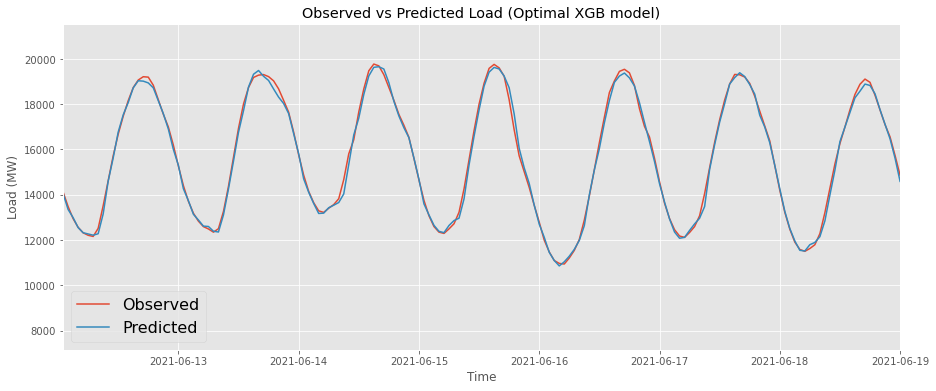

In [44]:
Plot_Pred(y_test, xgb_tunned.predict(X_test), 'Optimal XGB model')

The predicted values capture the observation very well. The only place where the prediction is not capturing the observation is at the peak values. 

### 4.7.3 Light GBM

In this section we will build a model using `light GBM` and compare it to the previous build models using `Elastic Net` and `XGB`

As usual, we will build a lightGBM model using default parameters and then we will tune the parameters

In [45]:
# A light GBM model using default values
dft_lgbm = gbm.LGBMRegressor()

dft_lgbm.fit(X_train_5yr,y_train_5yr)

ErrorMetrics(y_train_5yr,dft_lgbm.predict(X_train_5yr),'Default LGBM model for training data set')
ErrorMetrics(y_test,dft_lgbm.predict(X_test),'Default LGBM model for test data set ')

Error metrics for Default LGBM model for training data set
R2 score = 0.9978
MAE = 90.0357
RMSE =  124.1009
MAPE =  0.7521%
Error metrics for Default LGBM model for test data set 
R2 score = 0.9949
MAE = 133.1386
RMSE =  184.4272
MAPE =  1.0448%


(0.994931791509134, 184.42720840310702, 1.044837150343441)

In [173]:
# LightGBM hyperOpt optimization

lgbm_space = {'max_depth': hp.quniform("max_depth", 3, 21, 1),
            'subsample' : hp.uniform('subsample', 0.1,1.0),
            'num_leaves' : hp.quniform('num_leaves', 10, 200, 1),
            'learning_rate': hp.loguniform('learning_rate',np.log(0.001),np.log(1.0)),
            'reg_alpha' : hp.uniform('reg_alpha', 0,1),
            'reg_lambda' : hp.uniform('reg_lambda', 0,1),
            'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
    }

def lgbm_objective(lgbm_space):
    
    lgbm_model=gbm.LGBMRegressor(max_depth = int(lgbm_space['max_depth']), 
                                 num_leaves = int(lgbm_space['num_leaves']),
                                 learning_rate = lgbm_space['learning_rate'],
                                 subsample=lgbm_space['subsample'],
                                 reg_alpha = lgbm_space['reg_alpha'],
                                 reg_lambda = lgbm_space['reg_lambda'],
                                 colsample_bytree = lgbm_space['colsample_bytree'])
    
    evaluation = [(X_val, y_val)]
    
    lgbm_model.fit(X_tr, y_tr,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = lgbm_model.predict(X_val)
    mse= mean_squared_error(y_val, pred)
    print ("SCORE:", mse)
    return {'loss':mse, 'status': STATUS_OK, 'model': lgbm_model}


In [ ]:
start = timer()

X_tr = X_train_3yr[:-4320]
X_val = X_train_3yr[-4320:]
y_tr = y_train_3yr[:-4320]
y_val = y_train_3yr[-4320:]


trials = Trials()
lgbm_best = fmin(fn=lgbm_objective,
            space=lgbm_space,
            algo=tpe.suggest,
            max_evals=300,
            trials=trials)

end = timer()
print('elapsed time is',format(round(end-start)))

# best loss: 20993.88211227971
# elapsed time is 3219

In [175]:
# Print the best parameters from the hyper-parametera optimization
lgbm_best

{'colsample_by_tree': 0.9921449549873451,
 'learning_rate': 0.09149529115666252,
 'max_depth': 13.0,
 'num_leaves': 185.0,
 'reg_alpha': 0.6196757441934766,
 'reg_lambda': 0.6892423864644064,
 'subsample': 0.5381307248877378}

In [46]:
# Build a light GBM model with the best parameters estimated using all the training data.

lgbm_tunned = gbm.LGBMRegressor(max_depth=13,num_leaves=185,subsample=0.5381307248877378,
                                  learning_rate=0.09149529115666252,reg_alpha = 0.6196757441934766,
                                  reg_lambda = 0.6892423864644064,colsample_bytree = 0.9921449549873451)

lgbm_tunned.fit(X_train_5yr, y_train_5yr)

ErrorMetrics(y_train_5yr,lgbm_tunned.predict(X_train_5yr),'Best LGBM with hyper-parameters tunning for training data')
ErrorMetrics(y_test,lgbm_tunned.predict(X_test),'Best LGBM with hyper-parameters tunning for test data')

Error metrics for Best LGBM with hyper-parameters tunning for training data
R2 score = 0.9993
MAE = 53.6134
RMSE =  72.2330
MAPE =  0.4538%
Error metrics for Best LGBM with hyper-parameters tunning for test data
R2 score = 0.9962
MAE = 111.0135
RMSE =  160.5808
MAPE =  0.8657%


(0.9961576980768974, 160.58075687843453, 0.8656825061123327)

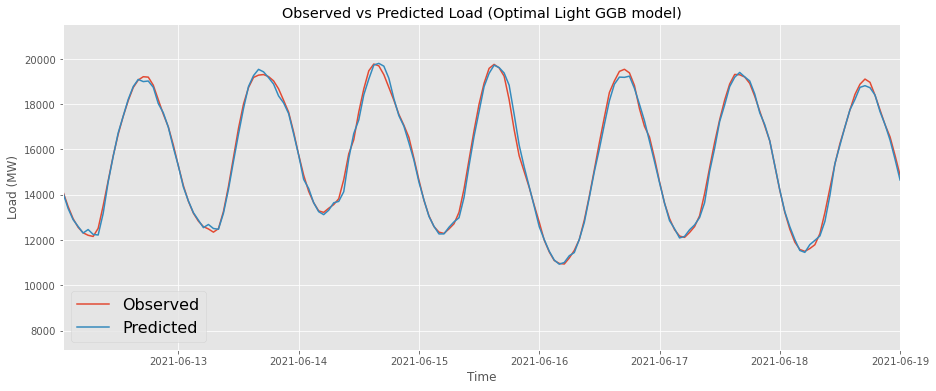

In [47]:
Plot_Pred(y_test, lgbm_tunned.predict(X_test), 'Optimal Light GGB model')

Similarl to the XGB, the plot shows the prediction is quite good and follows the observation very well with slight mismatch at the peak locations.

<p>&nbsp;</p>

## 4.8 Feature importance

We will take a look at which features have the highest impact on each of the models we built. We will explore the feature importance attribute from XGB & Light GBM and the sterngth of feature coefficients from the Elastic net model.
<p>&nbsp;</p>

In [85]:

def FeatureImportance(importance_var, col_names):
    
    """ This function will get the normalized feature importance
    the features improtance will be normalized by the maximum value.
    The most important feature will have a value of 100
    """
    col_names = X_train.columns.values
    
    feat_importance_norm = 100.0 * (importance_var/ importance_var.max())
    feat_importance_df = pd.DataFrame(list(zip(col_names,feat_importance_norm)), columns=['name','coef'])
    feat_importance_df['abs_coef'] = np.abs(feat_importance_df['coef'])
    feat_importance_df = feat_importance_df.sort_values('abs_coef', ascending=False)
    top_50_coef = feat_importance_df[:50].reset_index()
    top_50_coef.head()
    
    return feat_importance_df, top_50_coef


In [131]:
elc_coefficients = elc_tunned.coef_
xgb_feature_importance = xgb_tunned.feature_importances_
lgbm_feature_importance = lgbm_tunned.feature_importances_

Elastic_feature_importance, Elastic_top_50  = FeatureImportance(elc_coefficients,col_names)
xgb_feature_importance, xgb_top_50  = FeatureImportance(xgb_feature_importance,col_names)
lgbm_feature_importance, lgbm_top_50  = FeatureImportance(lgbm_feature_importance,col_names)

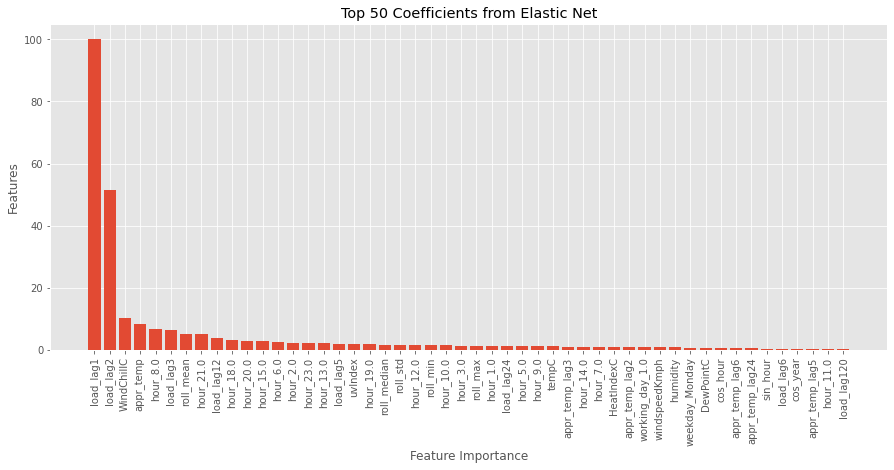

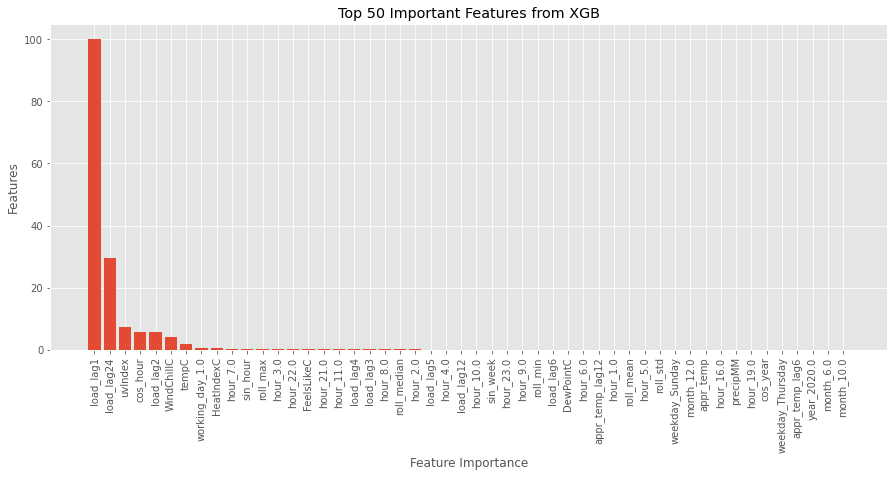

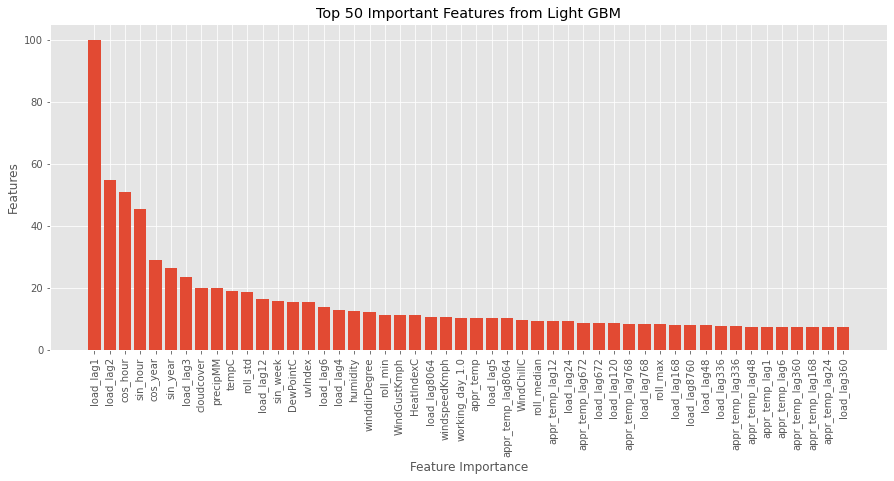

In [138]:
# plotting the top 50 important features

# Elastice Net

fig = plt.subplots(figsize=(15,6))
plt.bar(Elastic_top_50.index, np.abs(Elastic_top_50['coef']))
plt.xticks(Elastic_top_50.index, Elastic_top_50.name, rotation=90)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 50 Coefficients from Elastic Net')

# XGB

fig = plt.subplots(figsize=(15,6))
plt.bar(xgb_top_50.index, xgb_top_50['coef'])
plt.xticks(xgb_top_50.index, xgb_top_50.name, rotation=90)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 50 Important Features from XGB')

# Light GBM
fig = plt.subplots(figsize=(15,6))
plt.bar(lgbm_top_50.index, lgbm_top_50['coef'])
plt.xticks(lgbm_top_50.index, lgbm_top_50.name, rotation=90)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 50 Important Features from Light GBM')



plt.show()

From the importance of features and coefficients (incase of Elastic net), the load_lag1 is by far the most important feature, particularly in XGB model. The load_lag2 also cameout as the second most improtant feature both in the Elastic net and Light GBM models. This indicates that knowing the recent electric load consumption is very important in forecasting the near future. 

Some other observation include:

- It is important to note that, most of the top 50 important features are features that were generated by the feature engineering steps done in the previous notebooks. Therefore it is critical to spend sometime to create some relevant features to help the modeling stage
- As mentioned above, in XGM model, the load_lag1 is to dominant. The impact of the secod important feature on the model is only 1/3 of the first feature. The remaining top 10 features impact decreases rapidily and any feature beyound ten are almmost zero.
- the cyclic fourier terms created (for the hour and year) are in the top 6 important features in the LGBM model. However, they are not that important to the Elastic model.

## 4.9 Comparison of model performance

We will summarize the three best models performance and their residuals on the test data.

In [48]:
# calculate the residuals

elc_tunned_residuals = Residuals(y_test, elc_tunned.predict(X_test))
xgb_tunned_residuals = Residuals(y_test, xgb_tunned.predict(X_test))
lgbm_tunned_residuals = Residuals(y_test, lgbm_tunned.predict(X_test))

In [49]:
# create a dataframe containing the three residuals

model_names = ['Elastic Net','XGB','Light GBM']
residual_list = list(zip(elc_tunned_residuals,xgb_tunned_residuals,lgbm_tunned_residuals))
residuals_df = pd.DataFrame(residual_list, columns=model_names)
residuals_df.head()

,Elastic Net,XGB,Light GBM
0,44.131986,-70.107711,-15.275329
1,5.005341,-4.333175,-21.678107
2,62.728281,102.250600,99.097798
3,8.085485,3.052752,-21.317239
4,-11.382213,3.477598,22.381105


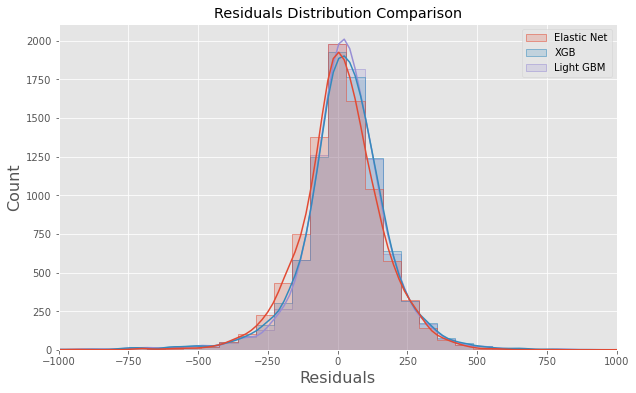

In [50]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(residuals_df, bins=60, element='step', alpha=0.2, kde=True)
plt.xlabel('Residuals', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.title('Residuals Distribution Comparison')
plt.xlim([-1000,1000])
plt.show()


The residual distribution from the three models show a normal distribution. They are all narrow, with the peaks centered around zero, indicating good performance.

In [52]:
# Prepare a summary dataframe comparing the three models, errors and confidence intervals
mdl_name = [elc_tunned,xgb_tunned,lgbm_tunned]
residual_list = [elc_tunned_residuals,xgb_tunned_residuals,lgbm_tunned_residuals]

model_summary_dict = {}

for name, residual in zip(mdl_name, residual_list):
    r2, rmse, mape = ErrorMetrics(y_test, name.predict(X_test))
    upper,lower = LowerUpperBound(residual)
    
    model_summary_dict[name]=r2,rmse,mape,upper,lower

model_summary_df = pd.DataFrame(model_summary_dict)

In [53]:
model_summary_df.columns = ['Elastic Net','XGB','Light GBM']
model_summary_df.index = ['R2','RMSE','MAPE','Lower_bound', 'Upper_bound']
model_summary_df.T

,R2,RMSE,MAPE,Lower_bound,Upper_bound
Elastic Net,0.996601,151.036736,0.877458,-283.218020,307.026918
XGB,0.996034,163.149819,0.891434,-289.565551,341.768484
Light GBM,0.996158,160.580757,0.865683,-283.579576,337.114167


Over all the three models give excellent performance and are comparable with each other. 
- Considering the amount of time it take to perform hyper-parameter tunning, XGB has slight disadvantage as it takes by far the longest time to perform the hyper parameter tunning. 
- Light GBM has the smallest MAPE, eventhough it has a lot of parameters to tune (similar top XGB), the computation is faster than XGB. 
- Elastic Net has few parameters to tune and is usually very fast compared to the boosting methods.

## 4.10 Saving models

Save the best models build in this notebook for future evaluation and comparison. We will save the three best optimized models for Elastic Net, XGB and Light GBM.

In [226]:
# Save the models as well us the version of some of the libraries used
ElasticNet_best_model = elc_tunned
ElasticNet_best_model.version = '1.0'
ElasticNet_best_model.pandas_version = pd.__version__
ElasticNet_best_model.numpy_version = np.__version__
ElasticNet_best_model.sklearn_version = sklearn_version
ElasticNet_best_model.X_columns = [col for col in X_train_5yr.columns]
ElasticNet_best_model.build_datetime = datetime.now()

XGB_best_model = xgb_tunned
XGB_best_model.version = '1.0'

LightGBM_best_model = lgbm_tunned
LightGBM_best_model.version = '1.0'

In [2]:
# save the model

modelpath = './models'
save_file(ElasticNet_best_model, 'ElasticNet_Best_forecasting_model.pkl', modelpath)
save_file(XGB_best_model, 'XGBM_Best_forecasting_model.pkl', modelpath)
save_file(LightGBM_best_model, 'LightGBM_Best_forecasting_model.pkl', modelpath)

##  4.11 Summary

In this notebook, we created the fourier cyclic terms and continued building our models. Some of the items done in this notebook are summarized below :

- We added new features encompassing the fourier cyclic terms. Cyclic variables are extracted in order to capture the cyclic nature of load time series. The effect of adding this terms was evaluated using a linear regression model. The model performance did not change much when adding these terms

- Out training data has roughly 11 years worth of data (with hourly frequency) and it will take quite long time to perform hyper parameter tunning. A benchmark test was conducted to see if using a subset of the data can give similar results to using all the data. A test using 5 and 3 years of data instead of all were finally selected as they give similar to slightly better results. The 3 years data was used when doing the hyper-parameter tunning and then the final best model was fitted using the 5 year data.

- Hyper parameter tunning for three methods (Elastic Net, XGB and Light GBM) were performed. Using the nest hyper-parameter, a model was built for each method. All the three best models performed very well on the test datasets. The residuals distribution from each model was narrow and centered around zero, as you would expected from a good model. 
- Overall, the result from the three models are quite comparable. Considering the time needed to do hyper-parameter tunning, Elastic Net and Light GBM have slight edge over XGB.



## 4.12 Next steps

- In the next notebook, we will build a model using SARIMAX and compare its performance to the above models. 
- In addition, the nextbook will delve more on trying to explain and interpret the models. We will utilize the python package `SHAP` to help understand the explainability and interpretability of the models